In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchaudio
import torchaudio.functional as F
from scipy.signal import coherence
from scipy.signal import welch, csd
from tqdm.notebook import tqdm

sys.path.append("/home/david/Documents/Codes/postgresql/")
from utils_psql import *

%load_ext autoreload
%autoreload 2

In [86]:
path_env = '/home/david/Documents/Codes/postgresql/.env'

db = ConnectDB(path_env)

query = """SELECT audios.name, audios.folder, audios.path, audios.date, audios.time 
           FROM audios
           WHERE audios.folder = 'G21A'
           OR audios.folder = 'G60A'
           OR audios.folder = 'S1A'
           OR audios.folder = 'S2A'; """

db.execute(query)
dfa = db.fetchall()

query = """SELECT audios.name, audios.folder, audios.path, audios.date, audios.time 
           FROM audios
           WHERE audios.folder = 'G21S'
           OR audios.folder = 'G60S'
           OR audios.folder = 'S1S'
           OR audios.folder = 'S2S'; """

db.execute(query)
dfs = db.fetchall()

dfa.sort_values(['date','time'], inplace=True)
dfs.sort_values(['date','time'], inplace=True)

In [87]:
conn = db.get_conn()  
loader = DataLoaderDB(conn)
df = pd.DataFrame(columns=['cod_audios','folder1','folder2','sxx','syy','sxy','freq'])
temp = []

for i, r in enumerate(dfa.iterrows()):
    print(f'{i} \t of \t {len(dfa)} ')
    x, sra = torchaudio.load(r[1]['path'])
    y, srs = torchaudio.load(dfs.iloc[i].path)
    y = y[0,:]
    x = F.resample(x, sra, srs)
    fs = srs
    
    f, Sxx = welch(x, fs=fs, nperseg=512, noverlap=0)
    f, Syy = welch(x, fs=fs, nperseg=512, noverlap=0)
    f, Sxy = csd(x, y, fs=fs, nperseg=512, noverlap=0)
    
    cod_audios = f'{r[1].folder}_{dfs.iloc[i].folder}_{dfs.iloc[i].date}_{dfs.iloc[i].time}'
    
    
    temp.append([cod_audios,
               r[1].folder,
               dfs.iloc[i].folder,
               Sxx.tolist()[0],
               Syy.tolist()[0],
               Sxy.tolist()[0],
               f.tolist()])  


0 	 of 	 5464 
1 	 of 	 5464 
2 	 of 	 5464 
3 	 of 	 5464 
4 	 of 	 5464 
5 	 of 	 5464 
6 	 of 	 5464 
7 	 of 	 5464 
8 	 of 	 5464 
9 	 of 	 5464 
10 	 of 	 5464 
11 	 of 	 5464 
12 	 of 	 5464 
13 	 of 	 5464 
14 	 of 	 5464 
15 	 of 	 5464 
16 	 of 	 5464 
17 	 of 	 5464 
18 	 of 	 5464 
19 	 of 	 5464 
20 	 of 	 5464 
21 	 of 	 5464 
22 	 of 	 5464 
23 	 of 	 5464 
24 	 of 	 5464 
25 	 of 	 5464 
26 	 of 	 5464 
27 	 of 	 5464 
28 	 of 	 5464 
29 	 of 	 5464 
30 	 of 	 5464 
31 	 of 	 5464 
32 	 of 	 5464 
33 	 of 	 5464 
34 	 of 	 5464 
35 	 of 	 5464 
36 	 of 	 5464 
37 	 of 	 5464 
38 	 of 	 5464 
39 	 of 	 5464 
40 	 of 	 5464 
41 	 of 	 5464 
42 	 of 	 5464 
43 	 of 	 5464 
44 	 of 	 5464 
45 	 of 	 5464 
46 	 of 	 5464 
47 	 of 	 5464 
48 	 of 	 5464 
49 	 of 	 5464 
50 	 of 	 5464 
51 	 of 	 5464 
52 	 of 	 5464 
53 	 of 	 5464 
54 	 of 	 5464 
55 	 of 	 5464 
56 	 of 	 5464 
57 	 of 	 5464 
58 	 of 	 5464 
59 	 of 	 5464 
60 	 of 	 5464 
61 	 of 	 5464 
62 	 of 	 5464 
63

In [91]:
df = pd.DataFrame(temp, columns=['cod_audios','folder1','folder2','sxx','syy','sxy','freq'])

In [ ]:
df.sxx = [np.array(sx) for sx in df.sxx] 
df.syy = [np.array(sy) for sy in df.syy] 
df.sxy = [np.array(sxy) for sxy in df.sxy] 

In [121]:
Pxx = df.sxx.mean()
Pyy = df.syy.mean()
Pxy = df.sxy.mean()

coh = np.abs(Pxy) / (np.sqrt(Pxx) * np.sqrt(Pyy))

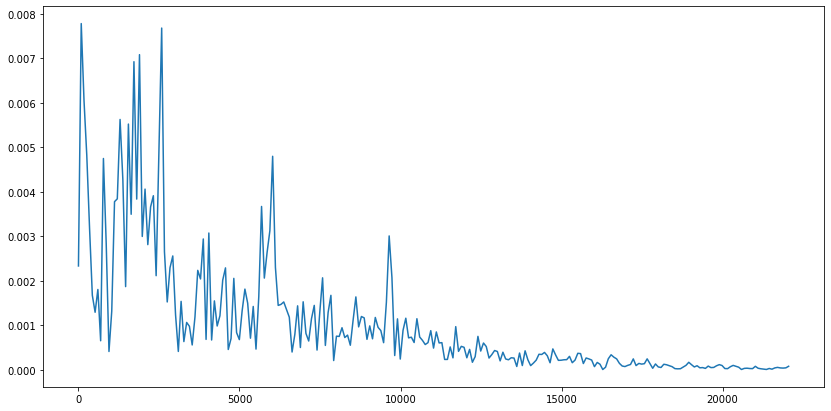

In [126]:
fig,ax = plt.subplots(1,1,figsize=(14,7))

plt.plot(df.freq[0],coh)

In [128]:
torch.save(df,'df_coherence.pth')